In [107]:
import asyncio
import websockets
import json
import pandas as pd
import datetime as dt
import nest_asyncio
nest_asyncio.apply()

from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm



async def call_api(msg):
   # Create API Websocket
   async with websockets.connect('wss://test.deribit.com/ws/api/v2') as websocket:
       await websocket.send(msg)
       while websocket.open:
           response = await websocket.recv()
           return response

def get_timeframes():
    timeframes = {'1min':1,'3min':3,'5min':5,'10min':10,'15min':15,'30min':30,'1hr':60,'2hr':'120','3hr':180,'6hr':360,'12hr':720,'1d':'1D'}
    return timeframes

def async_loop(api, message):
    return asyncio.get_event_loop().run_until_complete(api(message))



def retrieve_hist_data(start, end, instrument, timeframe):
    '''
    Function generates historical price data for the instrument
    Params:
    1. start: the start date in unix time format * 1000
    2. end: the end date in unix time format * 1000
    3. instrument: the desired instrument of interest
    4. timeframe: determines the granularity of data used
    '''
    msg = \
        {
            "jsonrpc": "2.0",
            "id": 832,
            "method": "public/get_tradingview_chart_data",
            "params": {
                "instrument_name": instrument,
                "start_timestamp": start,
                "end_timestamp": end,
                "resolution": timeframe
            }
        }
    json_resp = async_loop(call_api, json.dumps(msg))
    res = json.loads(json_resp)
    df = pd.DataFrame(res['result'])
    df['ticks'] = df.ticks / 1000
    df['timestamp'] = [dt.datetime.fromtimestamp(date) for date in df.ticks]
    df.set_index('timestamp',inplace = True)
    return df

def retrieve_hist_vol_idx(start,end,currency,timeframe):
    msg = \
    {
    "jsonrpc" : "2.0",
    "id" : 833,
    "method" : "public/get_volatility_index_data",
    "params" : {
        "currency" : currency,
        "start_timestamp" : start,
        "end_timestamp" : end,
        "resolution" : timeframe
    }
    }
    json_resp = async_loop(call_api,json.dumps(msg))
    res = json.loads(json_resp)
    df = pd.DataFrame(res['result']['data'])
    df.columns = ['timestamp','open','high','low','close']
    df['timestamp'] = [dt.datetime.fromtimestamp(date) for date in df['timestamp']/1000]
    df.set_index('timestamp',inplace = True)
    return df

def get_idx_price(idx_name="BTC"):
    if idx_name == 'BTC':
        idx_name = 'btc_usd'
    elif idx_name =='ETH':
        idx_name ='eth_usd'
    elif idx_name =='SOL':
        idx_name = 'sol_usd'
    msg = \
        {"jsonrpc": "2.0",
        "method": "public/get_index_price",
        "id": 42,
        "params": {
            "index_name": idx_name}
        }
    json_resp = async_loop(call_api,json.dumps(msg))
    res = json.loads(json_resp)
    return res['result']['index_price']


def get_all_active_options(currency = 'BTC'):
    import urllib.request, json
    url =  f"https://deribit.com/api/v2/public/get_instruments?currency={currency}&kind=option&expired=false"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.DataFrame(data['result']).set_index('instrument_name')
    data['creation_date'] = pd.to_datetime(data['creation_timestamp'], unit='ms')
    data['expiration_date'] = pd.to_datetime(data['expiration_timestamp'], unit='ms')
    print(f'{data.shape[0]} active options.')
    return data


# Get Tick data for a given instrument from the Deribit API
def get_tick_data(instrument_name):
    import urllib.request, json
    url =  f"https://deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = json_normalize(data['result'])
    #data.index = [instrument_name]
    return data
### Add additional metrics to data



def get_atm_strike(curncy='BTC',type = 'C'):
    curr_price = get_idx_price(idx_name=curncy)
    active_options = get_all_active_options(currency = curncy)
    active_options['type'] = [cont[-1] for cont in active_options.index]
    active_options = active_options[active_options['type']==type]
    atm_cont = active_options.loc[(active_options['strike']-curr_price).abs().idxmin()].name
    return atm_cont


    



In [48]:
#Get the atm strike for a given currency
active_option = get_atm_strike(curncy = 'ETH',type='P')

646 active options.


In [212]:
#Get the current trading price given the currency
get_idx_price('BTC')

42844.14

In [215]:
#Get historical data
start = int(dt.datetime.today().timestamp()*1000)-60*60*24*10*1000
end = int(dt.datetime.today().timestamp()*1000)
instrument = "ETH-23FEB24-2300-C"
timeframe = '60'
data = retrieve_hist_data(start,end,'ETH-PERPETUAL',timeframe)


In [160]:
eth_call = retrieve_hist_data(start,end,instrument,timeframe)

<Axes: xlabel='timestamp'>

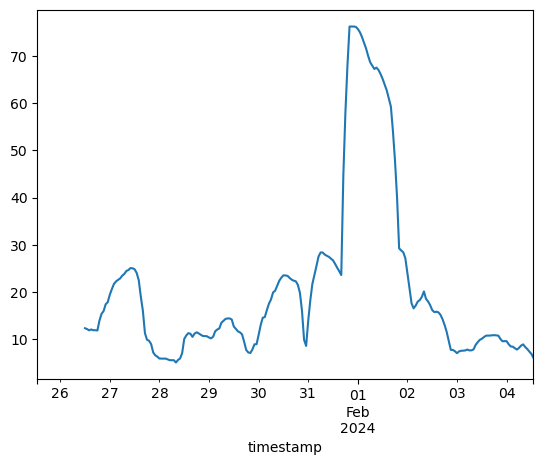

In [175]:
data['close'].rolling(24).std().plot()

<Axes: xlabel='timestamp'>

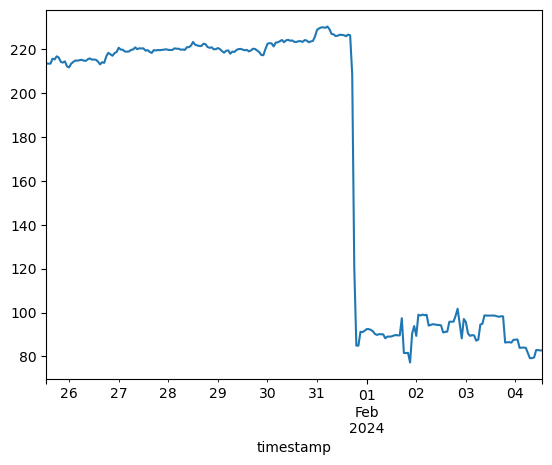

In [176]:
(eth_call['close']*data['close']).plot()

In [231]:
eth_active_options[(eth_active_options['option_type']=='call')&(eth_active_options['expiration_timestamp']==1711699200000)].sort_values('strike').index

Index(['ETH-29MAR24-200-C', 'ETH-29MAR24-400-C', 'ETH-29MAR24-500-C',
       'ETH-29MAR24-600-C', 'ETH-29MAR24-800-C', 'ETH-29MAR24-1000-C',
       'ETH-29MAR24-1200-C', 'ETH-29MAR24-1400-C', 'ETH-29MAR24-1500-C',
       'ETH-29MAR24-1600-C', 'ETH-29MAR24-1700-C', 'ETH-29MAR24-1800-C',
       'ETH-29MAR24-1900-C', 'ETH-29MAR24-2000-C', 'ETH-29MAR24-2100-C',
       'ETH-29MAR24-2200-C', 'ETH-29MAR24-2300-C', 'ETH-29MAR24-2400-C',
       'ETH-29MAR24-2500-C', 'ETH-29MAR24-2600-C', 'ETH-29MAR24-2700-C',
       'ETH-29MAR24-2800-C', 'ETH-29MAR24-2900-C', 'ETH-29MAR24-3000-C',
       'ETH-29MAR24-3100-C', 'ETH-29MAR24-3200-C', 'ETH-29MAR24-3300-C',
       'ETH-29MAR24-3400-C', 'ETH-29MAR24-3500-C', 'ETH-29MAR24-4000-C',
       'ETH-29MAR24-4500-C', 'ETH-29MAR24-5000-C', 'ETH-29MAR24-5500-C',
       'ETH-29MAR24-6000-C', 'ETH-29MAR24-6500-C', 'ETH-29MAR24-7000-C',
       'ETH-29MAR24-7500-C'],
      dtype='object', name='instrument_name')

In [236]:
sample_cont = eth_active_options[(eth_active_options['option_type']=='call')&(eth_active_options['expiration_timestamp']==1711699200000)].sort_values('strike').index[0]

In [240]:
sample_cont.split('-')[2]

'200'

In [241]:
from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers = 20)
option_chain = pd.DataFrame()
for data in pool.map(get_tick_data,eth_active_options[(eth_active_options['option_type']=='call')&(eth_active_options['expiration_timestamp']==1711699200000)].sort_values('strike').index):
    option_chain= pd.concat([option_chain,data])
option_chain['strike'] = [strike.split('-')[2] for strike in option_chain['instrument_name']]

C:\Users\kmavy\AppData\Local\Temp\ipykernel_30288\1312040061.py:120: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  data = json_normalize(data['result'])
C:\Users\kmavy\AppData\Local\Temp\ipykernel_30288\1312040061.py:120: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  data = json_normalize(data['result'])
C:\Users\kmavy\AppData\Local\Temp\ipykernel_30288\1312040061.py:120: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  data = json_normalize(data['result'])
C:\Users\kmavy\AppData\Local\Temp\ipykernel_30288\1312040061.py:120: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  data = json_normalize(data['result'])
C:\Users\kmavy\AppData\Local\Temp\ipykernel_30288\1312040061.py:120: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  data = json_normal

<Axes: xlabel='strike'>

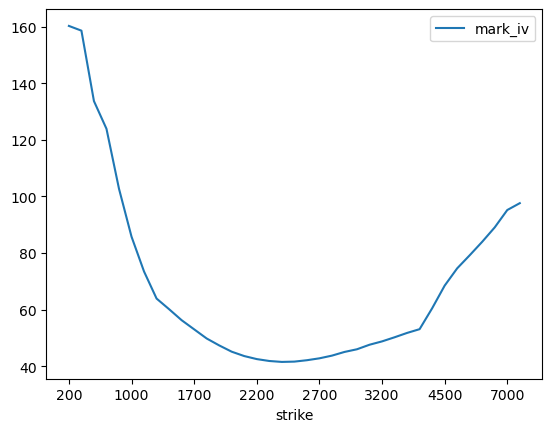

In [244]:
option_chain[['strike','mark_iv']].set_index('strike').plot()D

In [233]:
data['instrument_name']

0    ETH-29MAR24-7500-C
Name: instrument_name, dtype: object

In [230]:
raw_data.columns

Index(['estimated_delivery_price', 'best_bid_amount', 'best_ask_amount',
       'bid_iv', 'ask_iv', 'underlying_index', 'underlying_price', 'mark_iv',
       'best_bid_price', 'best_ask_price', 'interest_rate', 'mark_price',
       'open_interest', 'max_price', 'min_price', 'settlement_price',
       'last_price', 'instrument_name', 'index_price', 'state', 'timestamp',
       'greeks.rho', 'greeks.theta', 'greeks.vega', 'greeks.gamma',
       'greeks.delta', 'stats.volume_usd', 'stats.volume',
       'stats.price_change', 'stats.low', 'stats.high'],
      dtype='object')

In [179]:
eth_active_options = get_all_active_options('ETH')

646 active options.


In [184]:
eth_active_options.columns

Index(['tick_size_steps', 'quote_currency', 'min_trade_amount',
       'expiration_timestamp', 'counter_currency', 'settlement_period',
       'settlement_currency', 'block_trade_tick_size',
       'block_trade_min_trade_amount', 'block_trade_commission', 'option_type',
       'creation_timestamp', 'instrument_id', 'base_currency', 'contract_size',
       'tick_size', 'instrument_type', 'taker_commission', 'maker_commission',
       'strike', 'is_active', 'kind', 'rfq', 'price_index', 'creation_date',
       'expiration_date'],
      dtype='object')

In [207]:
strikes = eth_active_options[(eth_active_options['option_type']=='call')&(eth_active_options['expiration_timestamp']==1711699200000)].sort_values('strike')['strike'].values

In [200]:
ivs = [get_tick_data(contract)['mark_iv'][0] for contract in eth_active_options[(eth_active_options['option_type']=='call')&(eth_active_options['expiration_timestamp']==1711699200000)].sort_values('strike').index]


C:\Users\kmavy\AppData\Local\Temp\ipykernel_30288\1312040061.py:120: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  data = json_normalize(data['result'])
C:\Users\kmavy\AppData\Local\Temp\ipykernel_30288\1312040061.py:120: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  data = json_normalize(data['result'])
C:\Users\kmavy\AppData\Local\Temp\ipykernel_30288\1312040061.py:120: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  data = json_normalize(data['result'])
C:\Users\kmavy\AppData\Local\Temp\ipykernel_30288\1312040061.py:120: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  data = json_normalize(data['result'])
C:\Users\kmavy\AppData\Local\Temp\ipykernel_30288\1312040061.py:120: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  data = json_normal

<Axes: >

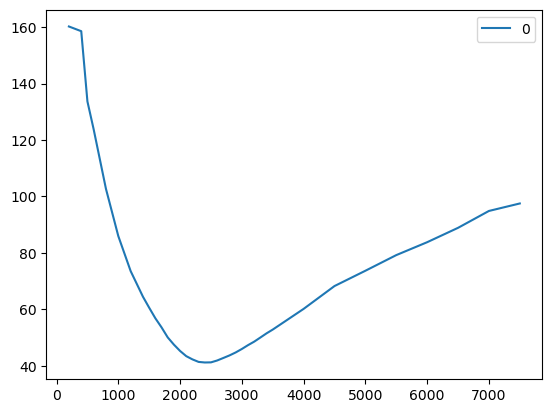

In [211]:
pd.DataFrame(ivs,index = strikes).plot()

In [192]:
tick['mark_iv'][0]

136.6

In [152]:
(80.7+84.17)/2

82.435

In [147]:
get_all_active_options()

860 active options.


,tick_size_steps,quote_currency,min_trade_amount,expiration_timestamp,counter_currency,settlement_period,settlement_currency,block_trade_tick_size,block_trade_min_trade_amount,block_trade_commission,...,instrument_type,taker_commission,maker_commission,strike,is_active,kind,rfq,price_index,creation_date,expiration_date
instrument_name,,,,,,,,,,,,,,,,,,,,,
BTC-4FEB24-37000-C,"[{'above_price': 0.005, 'tick_size': 0.0005}]",BTC,0.1,1707033600000,USD,day,BTC,0.0001,25,0.0003,...,reversed,0.0003,0.0003,37000.0,True,option,False,btc_usd,2024-02-01 08:15:00,2024-02-04 08:00:00
BTC-4FEB24-37000-P,"[{'above_price': 0.005, 'tick_size': 0.0005}]",BTC,0.1,1707033600000,USD,day,BTC,0.0001,25,0.0003,...,reversed,0.0003,0.0003,37000.0,True,option,False,btc_usd,2024-02-01 08:15:00,2024-02-04 08:00:00
BTC-4FEB24-38000-C,"[{'above_price': 0.005, 'tick_size': 0.0005}]",BTC,0.1,1707033600000,USD,day,BTC,0.0001,25,0.0003,...,reversed,0.0003,0.0003,38000.0,True,option,False,btc_usd,2024-02-01 08:01:00,2024-02-04 08:00:00
BTC-4FEB24-38000-P,"[{'above_price': 0.005, 'tick_size': 0.0005}]",BTC,0.1,1707033600000,USD,day,BTC,0.0001,25,0.0003,...,reversed,0.0003,0.0003,38000.0,True,option,False,btc_usd,2024-02-01 08:01:00,2024-02-04 08:00:00
BTC-4FEB24-38500-C,"[{'above_price': 0.005, 'tick_size': 0.0005}]",BTC,0.1,1707033600000,USD,day,BTC,0.0001,25,0.0003,...,reversed,0.0003,0.0003,38500.0,True,option,False,btc_usd,2024-02-01 08:01:00,2024-02-04 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BTC-27DEC24-160000-P,"[{'above_price': 0.005, 'tick_size': 0.0005}]",BTC,0.1,1735286400000,USD,month,BTC,0.0001,25,0.0003,...,reversed,0.0003,0.0003,160000.0,True,option,False,btc_usd,2023-12-28 08:00:09,2024-12-27 08:00:00
BTC-27DEC24-180000-C,"[{'above_price': 0.005, 'tick_size': 0.0005}]",BTC,0.1,1735286400000,USD,month,BTC,0.0001,25,0.0003,...,reversed,0.0003,0.0003,180000.0,True,option,False,btc_usd,2023-12-28 08:00:09,2024-12-27 08:00:00
BTC-27DEC24-180000-P,"[{'above_price': 0.005, 'tick_size': 0.0005}]",BTC,0.1,1735286400000,USD,month,BTC,0.0001,25,0.0003,...,reversed,0.0003,0.0003,180000.0,True,option,False,btc_usd,2023-12-28 08:00:09,2024-12-27 08:00:00


<Axes: xlabel='timestamp'>

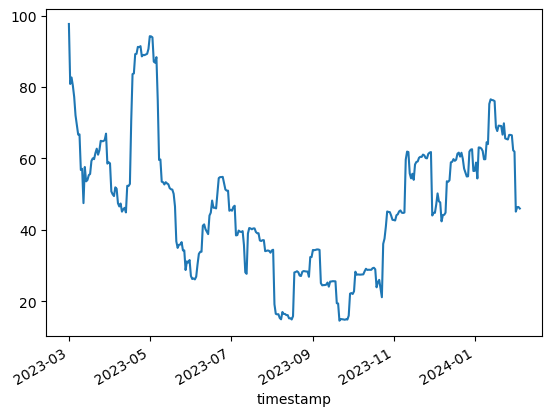

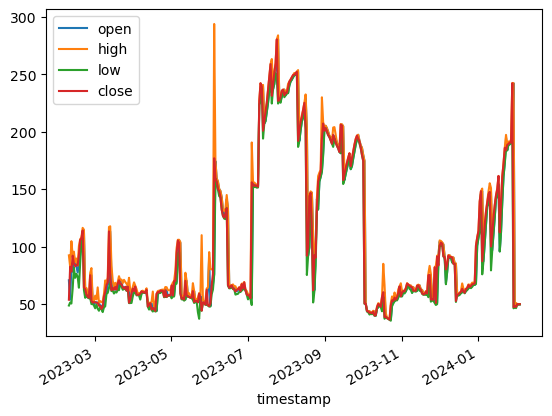

In [161]:
eth_df = retrieve_hist_data(start,end,instrument,timeframe)
vol = retrieve_hist_vol_idx(start,end,instrument[:3],timeframe)
eth_df['close'].diff().rolling(20).std().plot()
vol.plot()

<Axes: xlabel='timestamp'>

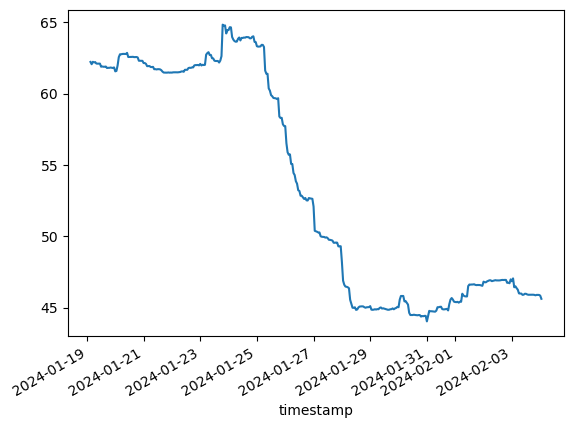

In [69]:
voLvol = retrieve_historic_vol('ETH')
vol.index = vol.timestamp
vol['vol'].plot()

In [45]:

retrieve_historic_data(start,end,instrument,timeframe)

,ticks,volume,cost,status,open,low,high,close,timestamp
0,1.606954e+09,6488.402877,1.251895e+08,ok,19243.5,18887.0,19648.5,19461.0,2020-12-03 08:00:00
1,1.607040e+09,17749.911178,3.377931e+08,ok,19461.0,17576.0,19577.5,18671.0,2020-12-04 08:00:00
2,1.607126e+09,8081.678536,1.540896e+08,ok,18660.0,18518.0,19269.0,19168.5,2020-12-05 08:00:00
3,1.607213e+09,48624.650505,9.302711e+08,ok,19169.5,18869.5,19445.5,19401.5,2020-12-06 08:00:00
4,1.607299e+09,65993.020334,1.271995e+09,ok,19399.5,18894.0,19580.0,19187.0,2020-12-07 08:00:00
...,...,...,...,...,...,...,...,...,...
1153,1.706515e+09,8115.914488,3.456086e+08,ok,42074.5,41818.0,43779.0,43400.5,2024-01-29 16:00:00
1154,1.706602e+09,6656.641152,2.876443e+08,ok,43390.0,42700.0,43924.5,43049.5,2024-01-30 16:00:00
1155,1.706688e+09,9877.403781,4.236066e+08,ok,43044.5,41852.0,43851.5,42188.5,2024-01-31 16:00:00
1156,1.706774e+09,8680.774919,3.709268e+08,ok,42167.5,41935.0,43557.5,43107.0,2024-02-01 16:00:00


In [32]:
res = json.loads(json_resp)

In [1]:


def get_atm_contract():
    active_options


In [203]:
curr_price = 43000
atm_cont = activ_options.loc[(activ_options['strike']-curr_price).abs().idxmin()].name
tick = get_tick_data(atm_cont)

C:\Users\kmavy\AppData\Local\Temp\ipykernel_23728\2282995035.py:19: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  data = json_normalize(data['result'])


In [206]:
tick

,estimated_delivery_price,best_bid_amount,best_ask_amount,bid_iv,ask_iv,underlying_index,underlying_price,mark_iv,best_bid_price,best_ask_price,...,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high
BTC-4FEB24-43000-C,43122.48,4.8,3.5,12.64,23.31,SYN.BTC-4FEB24,43128.891,16.71,0.0039,0.0055,...,0.48572,-53.71878,6.43044,0.00122,0.66959,26460.46,118.2,-49.4737,0.003,0.0095
